In [ ]:
# !wget https://physionet.org/static/published-projects/gaitpdb/gait-in-parkinsons-disease-1.0.0.zip
# !unzip /content/gait-in-parkinsons-disease-1.0.0.zip

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from keras.utils.training_utils import multi_gpu_model
from keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# !pip install keras==2.2.4

In [ ]:
files = glob.glob("/content/parkinsons/*_??.txt")
shuffle(files)

In [ ]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1

In [ ]:
fdf = pd.DataFrame(files)

# Do note that I am using a binary classification only below, use use getClassification for all classes
fdf['classification']  = fdf[0].map(lambda x: getClassForHealthyOrNot(x))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1917)
for train_index, test_index in split.split(fdf, fdf['classification']):
    strat_train = fdf.loc[train_index]
    strat_test  = fdf.loc[test_index]
    
train_files = strat_train[0].values
test_files = strat_test[0].values

In [ ]:
len(train_files), len(test_files)

(244, 62)

In [ ]:
# One-hot encoding, yes, Keras has one too, np_utils.to_categorical() - this made sense at the time

def parkinsonOneHot(label, len):
    onehot = np.zeros([len, 2])

    if (label == 0):
        onehot[:, 0] = 1
    else:
        onehot[:, 1] = 1
    return onehot

In [ ]:
# Initialize the scaler with training fileset

sc = StandardScaler()

def initScalerWith():
    d = pd.DataFrame()
    
    for f in train_files:
        data = pd.read_csv(f, sep='\t')
        data['classification'] = getClassForHealthyOrNot(f)
        d = pd.concat([data], axis=1)
    return d.values

sc.fit(initScalerWith())

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
# Read and label individual file

def readSensorDataFromFile(f):
    data = pd.read_csv(f, sep='\t')
    data['classification'] = getClassForHealthyOrNot(f)
    return sc.transform(data.values)

In [ ]:
# This method produces the matrices out, I am dropping few features, so only picking the sensor readings [1:17]

def produceImagesFromFile(file, image_height, offset=100):
    r = pd.DataFrame()
   
    # Width is 16 pixels
    d = readSensorDataFromFile(file)[:, 1:17]

    for i in range(0, d.shape[0], offset):
        if (i+image_height > d.shape[0]):
            continue
        r = pd.concat([r, pd.DataFrame(d[i:i+image_height])], axis=0)

    return r.values.reshape(-1, 16, image_height, 1), getClassForHealthyOrNot(file)

In [ ]:
# Python generator that produces data to be fed to the GPU. This is necessary if you do not want 
# the CPU to be the bottleneck for your computations.

batch_size = 16
image_height = 192

def generate_arrays_from_file(files):
    while 1:
         for f in files:
            #print("processing ", f)
            x_batch, y_class = produceImagesFromFile(f, image_height=image_height)
            y_batch = parkinsonOneHot(y_class, x_batch.shape[0])
       
            # Batch size defined as "batch_size" in the initialization
            for i in range (0, len(x_batch), batch_size):
                yield (x_batch[i:i+batch_size], y_batch[i:i+batch_size])

In [ ]:
def count_steps_in_epoch(files, batch_size = 64, image_height = 192):
    count = 0
    for f in files:
        xb, _ = produceImagesFromFile(f, image_height=image_height)
        count = count + int(xb.shape[0] / batch_size)
    return count

In [ ]:
batch_size = 16
image_height = 240

training_set_steps_per_epoch = count_steps_in_epoch(train_files, batch_size=batch_size, image_height=image_height)
test_set_steps_per_epoch = count_steps_in_epoch(test_files, batch_size=batch_size, image_height=image_height)

a,b = next(generate_arrays_from_file(test_files))

print("Training: ", training_set_steps_per_epoch, " samples, testing: ", test_set_steps_per_epoch)

Training:  1514  samples, testing:  382


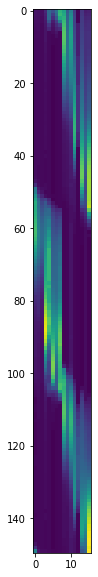

In [ ]:
# This is an example of what we are feeding to the convolutional network, illustrated as an image
# but instead of the height of 240 pixels, I am showing just the first 150.

plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(a[1].reshape(image_height, 16)[:150, :])
plt.show()

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs['val_accuracy'] >= 0.823:
      self.model.stop_training = True

In [ ]:
model = Sequential()
model.add(Conv2D(24, (7, 7), padding='same', kernel_initializer='glorot_uniform',
                 input_shape=a.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=60, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./model/model_parkinsons_v0.h5", 
                             monitor='val_accuracy', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 240, 24)       1200      
_________________________________________________________________
activation (Activation)      (None, 16, 240, 24)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 120, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 120, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 23040)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 46082     
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0

In [ ]:
# Use the fit_generator in conjunction with use_multiprocessing=True to get more performance out
# Do not use together with workers-parameter.

history = model.fit_generator(generate_arrays_from_file(train_files), 
                    validation_data=generate_arrays_from_file(test_files),
                    steps_per_epoch=training_set_steps_per_epoch, 
                    validation_steps=test_set_steps_per_epoch,
                    epochs=100, 
                    shuffle=True,
                    use_multiprocessing=True,
                   callbacks=[early_stopping, checkpoint, CustomCallback()])

Epoch 1/100
1532/1532 [==============================] - 33s 21ms/step - loss: 0.4478 - accuracy: 0.8807 - val_loss: 1.3738 - val_accuracy: 0.6946
Epoch 2/100
1532/1532 [==============================] - 32s 21ms/step - loss: 0.4045 - accuracy: 0.8950 - val_loss: 1.9288 - val_accuracy: 0.6945
Epoch 3/100
1532/1532 [==============================] - 32s 21ms/step - loss: 0.3819 - accuracy: 0.9005 - val_loss: 1.1011 - val_accuracy: 0.6945
Epoch 4/100
1532/1532 [==============================] - 32s 21ms/step - loss: 0.3521 - accuracy: 0.9100 - val_loss: 0.6190 - val_accuracy: 0.7591
Epoch 5/100
1532/1532 [==============================] - 32s 21ms/step - loss: 0.3142 - accuracy: 0.9184 - val_loss: 1.1903 - val_accuracy: 0.4931
Epoch 6/100
1532/1532 [==============================] - 33s 21ms/step - loss: 0.3296 - accuracy: 0.9164 - val_loss: 0.7217 - val_accuracy: 0.7491
Epoch 7/100
1532/1532 [==============================] - 33s 21ms/step - loss: 0.3073 - accuracy: 0.9233 - val_loss: 1

In [ ]:
new_model = load_model('/content/drive/My Drive/parkinsons.h5')

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 240, 24)       1200      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 240, 24)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 120, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 120, 24)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23040)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 46082     
_________________________________________________________________
activation_3 (Activation)    (None, 2)                

In [ ]:
n_park = 0
n_control = 0

for f in test_files:
    if (f.find("Co") > 0):
        n_control += 1
    else:
        n_park += 1

In [ ]:
n_control, n_park

(19, 43)

In [ ]:
correct = 0
incorrect = 0

true_y = []
predicted_y = []

for f in test_files:
    d_x, label = produceImagesFromFile(file=f, image_height=240)
    
    predictions = model.predict_classes(d_x)
    
    predict_distribution = pd.Series(predictions).value_counts()
    predictClass = predict_distribution.idxmax()
    
    true_y.append(label)
    predicted_y.append(predictClass)
    
    if (label == predictClass):
        prediction_text = "correct"
        correct += 1
    else:
        prediction_text = "incorrect (vote distribution: %s)" % (predict_distribution.values)
        incorrect += 1

    output = ("prediction was %s for %s") % (prediction_text, os.path.basename(f))
    print(output)

print(("Number of samples: %d, %d correct, %d incorrect.") % 
    (correct+incorrect, correct, incorrect))
print('accuracy = ' + str((correct / (correct + incorrect) * 100)))

prediction was incorrect (vote distribution: [39]) for JuCo03_01.txt
prediction was correct for GaCo17_10.txt
prediction was correct for JuPt17_01.txt
prediction was correct for JuPt21_06.txt
prediction was incorrect (vote distribution: [68 51]) for SiPt31_01.txt
prediction was incorrect (vote distribution: [117   2]) for GaPt21_02.txt
prediction was correct for JuPt01_03.txt
prediction was correct for JuPt20_04.txt
prediction was correct for JuCo23_01.txt
prediction was correct for JuPt20_02.txt
prediction was correct for JuPt06_07.txt
prediction was incorrect (vote distribution: [118   1]) for SiCo28_01.txt
prediction was correct for GaPt20_01.txt
prediction was incorrect (vote distribution: [53]) for JuPt02_01.txt
prediction was incorrect (vote distribution: [119]) for GaPt24_10.txt
prediction was incorrect (vote distribution: [119]) for GaPt15_02.txt
prediction was incorrect (vote distribution: [116   3]) for SiCo14_01.txt
prediction was correct for GaPt09_01.txt
prediction was inc

In [ ]:
from sklearn.metrics import recall_score, f1_score, precision_score
recall = recall_score(true_y, predicted_y)
precision = precision_score(true_y, predicted_y)
f1 = f1_score(true_y, predicted_y)

print('Recall score: {0:0.2f}'.format(recall))
print('Precision score: {0:0.2f}'.format(precision))
print('F1-score: {0:0.2f}'.format(precision))

Recall score: 0.98
Precision score: 0.89
F1-score: 0.89


In [ ]:
model.save('/content/drive/My Drive/parkinsons.h5')

In [ ]:
test_files

array(['/content/parkinsons/JuCo03_01.txt',
       '/content/parkinsons/GaCo17_10.txt',
       '/content/parkinsons/JuPt17_01.txt',
       '/content/parkinsons/JuPt21_06.txt',
       '/content/parkinsons/SiPt31_01.txt',
       '/content/parkinsons/GaPt21_02.txt',
       '/content/parkinsons/JuPt01_03.txt',
       '/content/parkinsons/JuPt20_04.txt',
       '/content/parkinsons/JuCo23_01.txt',
       '/content/parkinsons/JuPt20_02.txt',
       '/content/parkinsons/JuPt06_07.txt',
       '/content/parkinsons/SiCo28_01.txt',
       '/content/parkinsons/GaPt20_01.txt',
       '/content/parkinsons/JuPt02_01.txt',
       '/content/parkinsons/GaPt24_10.txt',
       '/content/parkinsons/GaPt15_02.txt',
       '/content/parkinsons/SiCo14_01.txt',
       '/content/parkinsons/GaPt09_01.txt',
       '/content/parkinsons/SiPt14_01.txt',
       '/content/parkinsons/GaPt21_10.txt',
       '/content/parkinsons/GaPt29_10.txt',
       '/content/parkinsons/JuPt20_06.txt',
       '/content/parkinsons/GaCo